#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf  # For TensorFlow 2.x, no need to disable v2 behavior

In [3]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()  # Must be first TF command

## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [4]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [5]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [14]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
144,0,102,subaru,gas,std,four,sedan,4wd,front,97.00,...,108,2bbl,3.62,2.64,9.00,82,4800,24,25,9233
46,2,?,isuzu,gas,std,two,hatchback,rwd,front,96.00,...,119,spfi,3.43,3.23,9.20,90,5000,24,29,11048
127,3,?,porsche,gas,std,two,hardtop,rwd,rear,89.50,...,194,mpfi,3.74,2.90,9.50,207,5900,17,25,34028


In [6]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']

LABEL = 'price'

# Define numeric_feature_names as a list of strings
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

# Calculate categorical_feature_names based on numeric_feature_names and LABEL
categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

# Assertions to check the lengths of the lists
assert len(numeric_feature_names) == 15  # This assertion should now pass
assert len(categorical_feature_names) == 10

In [7]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
20,0,81,94.50,158.80,63.60,52.00,1909,90,70,5400,38,43,3.03,3.11,9.60
49,0,?,102.00,191.70,70.60,47.80,3950,326,262,5000,13,17,3.54,2.76,11.50
54,1,113,93.10,166.80,64.20,54.10,1950,91,68,5000,31,38,3.08,3.15,9.00
35,0,110,96.50,163.40,64.00,54.50,2010,92,76,6000,30,34,2.91,3.41,9.20
119,1,119,93.70,157.30,63.80,50.80,2128,98,102,5500,24,30,3.03,3.39,7.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,128,94.50,165.30,63.80,54.50,1918,97,69,5200,31,37,3.15,3.29,9.40
13,0,188,101.20,176.80,64.80,54.30,2765,164,121,4250,21,28,3.31,3.19,9.00
103,0,108,100.40,184.60,66.50,55.10,3060,181,152,5200,19,25,3.43,3.27,9.00
29,3,145,95.90,173.20,66.30,50.20,2811,156,145,5000,19,24,3.60,3.90,7.00


In [8]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,engine-type,num-cylinders,fuel-system,drive-wheels,make,engine-location,body-style,aspiration,num-doors,fuel-type
20,ohc,four,2bbl,fwd,chevrolet,front,sedan,std,four,gas
49,ohcv,twelve,mpfi,rwd,jaguar,front,sedan,std,two,gas
54,ohc,four,2bbl,fwd,mazda,front,sedan,std,four,gas
35,ohc,four,1bbl,fwd,honda,front,sedan,std,four,gas
119,ohc,four,spdi,fwd,plymouth,front,hatchback,turbo,two,gas
...,...,...,...,...,...,...,...,...,...,...
91,ohc,four,2bbl,fwd,nissan,front,sedan,std,two,gas
13,ohc,six,mpfi,rwd,bmw,front,sedan,std,four,gas
103,ohcv,six,mpfi,fwd,nissan,front,sedan,std,four,gas
29,ohc,four,mfi,fwd,dodge,front,hatchback,turbo,two,gas


In [9]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Define batch size
batch_size = 16

# Prepare data
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input function using TensorFlow Dataset
# Instead of using dict(x_df), pass x_df.values directly
train_dataset = tf.data.Dataset.from_tensor_slices((x_df.values, y_series))
train_dataset = train_dataset.batch(batch_size).repeat()  # Repeat dataset for multiple epochs

# Build a more complex DNN model using Keras with regularization
model = tf.keras.Sequential([
    tf.keras.Input(shape=(x_df.shape[1],)),  # Input layer (shape inferred from data)
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.Dense(1)  # Output layer for regression
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    x_df.values, y_series.values,  # Ensure input is in numpy format
    epochs=100,  # Set epochs to 100
    batch_size=batch_size,
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model on the test set
# Instead of using dict(x_df), pass x_df.values directly
eval_dataset = tf.data.Dataset.from_tensor_slices((x_df.values, y_series))
eval_dataset = eval_dataset.batch(batch_size)

# Evaluate the model
loss, mae = model.evaluate(eval_dataset, steps=len(x_df) // batch_size)

print(f"\n✅ Test MSE (Loss): {loss:.2f}")
print(f"✅ Test MAE: {mae:.2f}")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 208887632.0000 - mae: 12197.4121 - val_loss: 246832272.0000 - val_mae: 13048.8965
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 166389456.0000 - mae: 10878.9766 - val_loss: 220197744.0000 - val_mae: 12044.3994
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 135769216.0000 - mae: 9503.6104 - val_loss: 189390032.0000 - val_mae: 10752.3184
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 122301200.0000 - mae: 8509.1992 - val_loss: 152419136.0000 - val_mae: 8946.1816
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 98216224.0000 - mae: 6680.7354 - val_loss: 114834368.0000 - val_mae: 6946.9175
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 61468904.0000 - mae: 4911.0796 - val_loss: 86104080.0000 - val_mae: 5862.8447
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 54110440.0000 - mae: 5155.4180 - val_loss: 76740544.0000 - val_mae: 5969.4985
Epoch 8/100
11/11 ━━━━━

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import pandas as pd
from sklearn.model_selection import train_test_split

# Prepare the data for training and evaluation
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_df, y_series, test_size=0.2, random_state=42)

# Model 1: DNN (Deep Neural Network)
print("Training DNN (Deep Neural Network)...")
dnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(1)  # Output layer for regression
])

# Compile and train the DNN model
dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss='mean_squared_error', metrics=['mae'])
dnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the DNN model
dnn_loss, dnn_mae = dnn_model.evaluate(X_test, y_test)
print("DNN Model Evaluation - Loss:", dnn_loss, "MAE:", dnn_mae)

# Model 2: Linear Regression (using Keras)
print("Training Linear Regression Model...")
linear_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(1)  # Linear regression layer
])

# Compile and train the linear regression model
linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss='mean_squared_error', metrics=['mae'])
linear_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the Linear Regression model
linear_loss, linear_mae = linear_model.evaluate(X_test, y_test)
print("Linear Regression Model Evaluation - Loss:", linear_loss, "MAE:", linear_mae)

# Model 3: Hybrid DNN + Linear Combined Regression (using Keras)
print("Training DNN + Linear Combined Model...")
combined_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(1)  # Output layer for regression
])

# Compile and train the combined model
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                       loss='mean_squared_error', metrics=['mae'])
combined_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the DNN + Linear Combined model
combined_loss, combined_mae = combined_model.evaluate(X_test, y_test)
print("DNN + Linear Combined Model Evaluation - Loss:", combined_loss, "MAE:", combined_mae)


Training DNN (Deep Neural Network)...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 198827296.0000 - mae: 11575.1924 - val_loss: 48317616.0000 - val_mae: 4872.0312
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 103830072.0000 - mae: 6574.9634 - val_loss: 77403616.0000 - val_mae: 7668.4717
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 95496016.0000 - mae: 7944.2656 - val_loss: 41796740.0000 - val_mae: 5414.7456
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 58474724.0000 - mae: 5313.7852 - val_loss: 35780136.0000 - val_mae: 4262.9404
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 70866824.0000 - mae: 5675.6924 - val_loss: 31003048.0000 - val_mae: 4368.0527
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 55012144.0000 - mae: 5085.5752 - val_loss: 38085696.0000 - val_mae: 5171.0342
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 59301532.0000 - mae: 5816.6172 - val_loss: 27572158.0000 - val_mae: 4172.7080
Epoch 8/50
6/6

In [ ]:
'''#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

'''

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


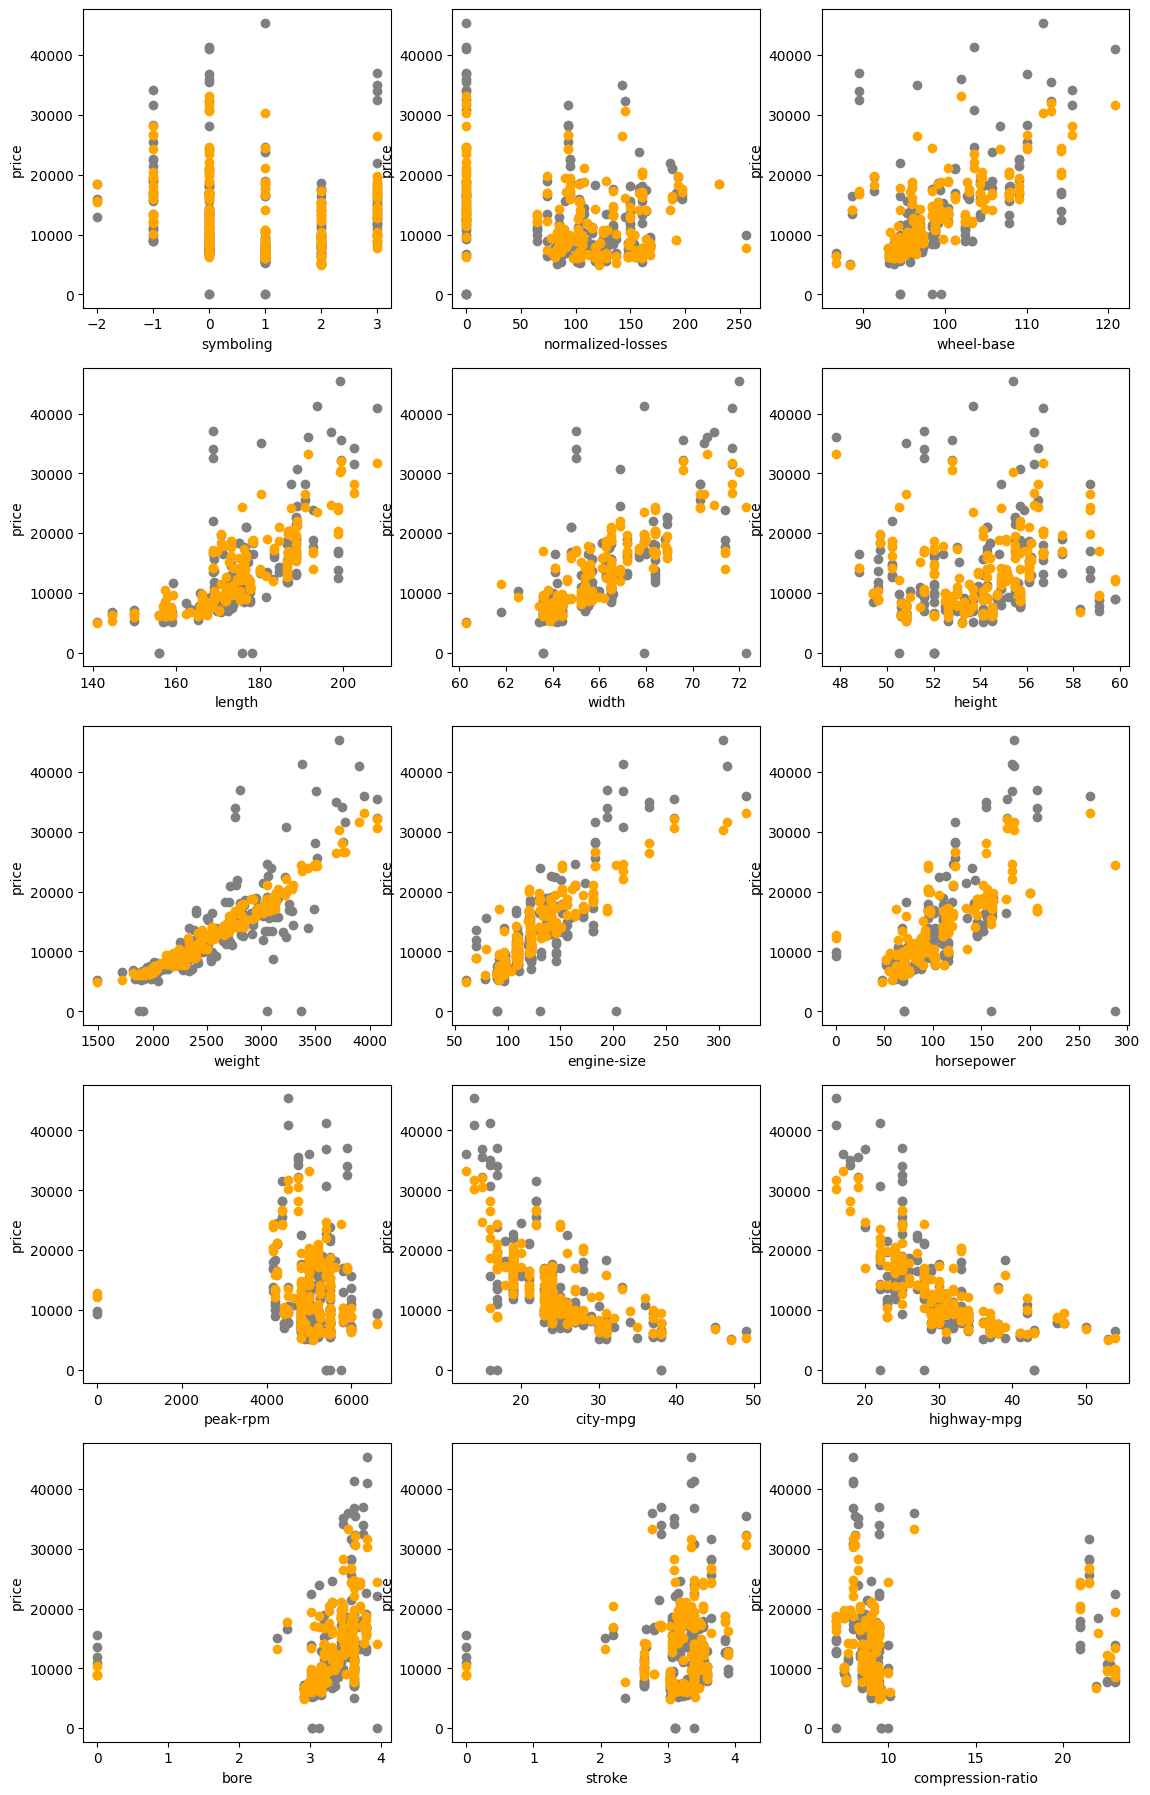

In [15]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(model, x_df, feature_names): # Changed est to model
  """Plots the predictions of the model against each feature.

  Args:
    model: The trained Keras model. # Changed description
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')


  predictions = model.predict(x_df[numeric_feature_names]) # Changed to use model.predict

  # For predictions, we need to flatten the output if it's a 2D array
  predictions = predictions.flatten()

  import math # Importing math for ceil function
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)

  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(model, x_df, numeric_feature_names) # Changed est to model

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

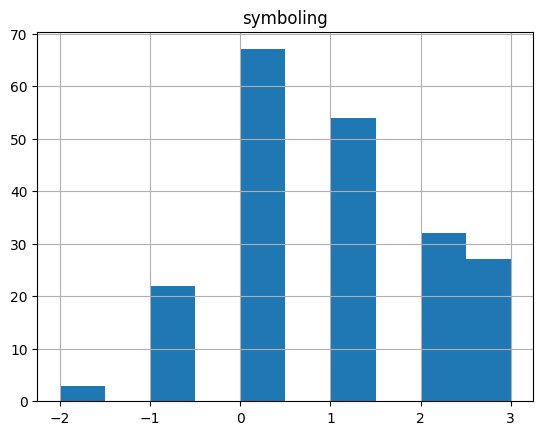

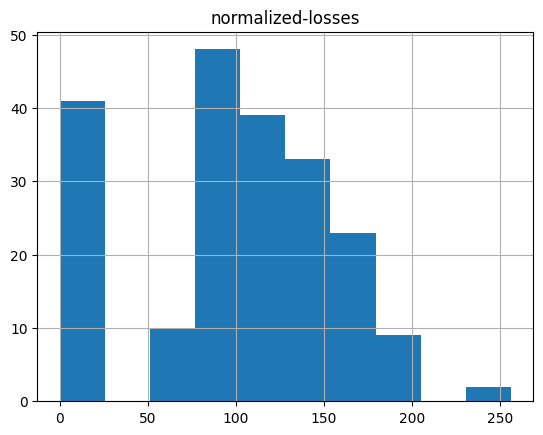

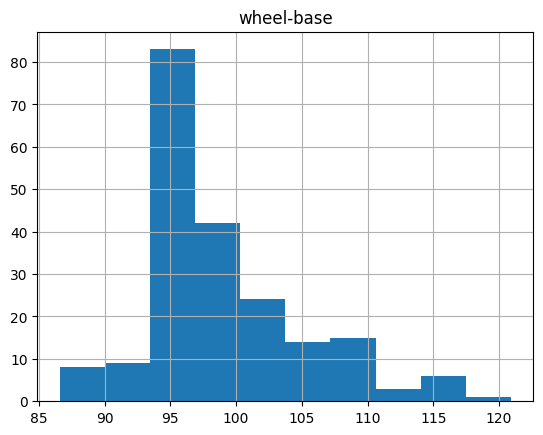

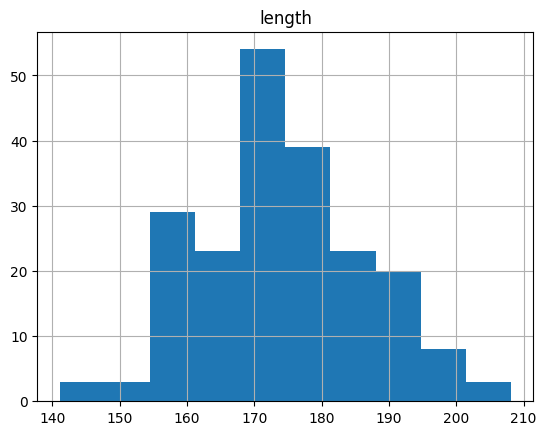

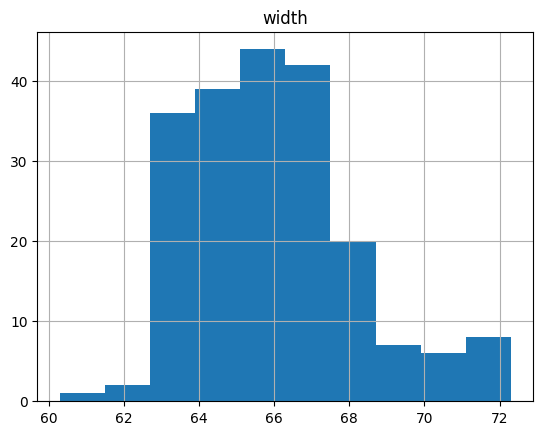

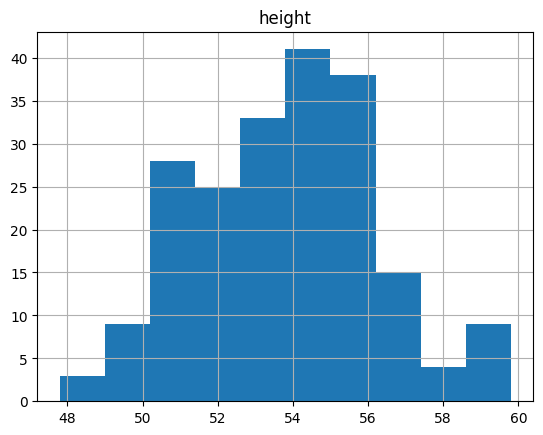

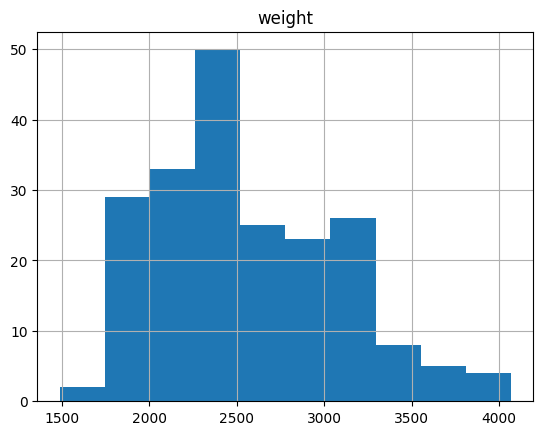

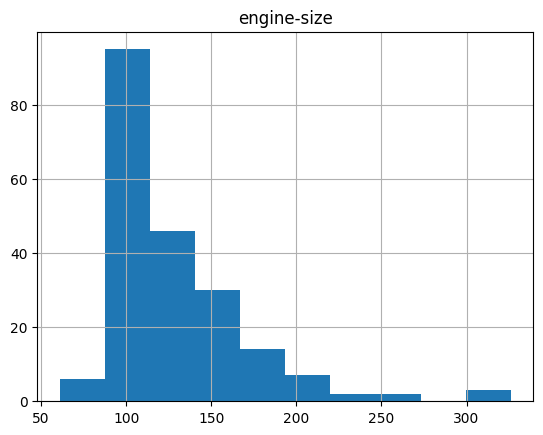

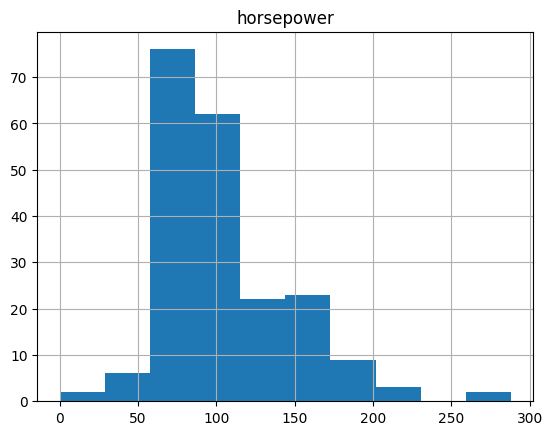

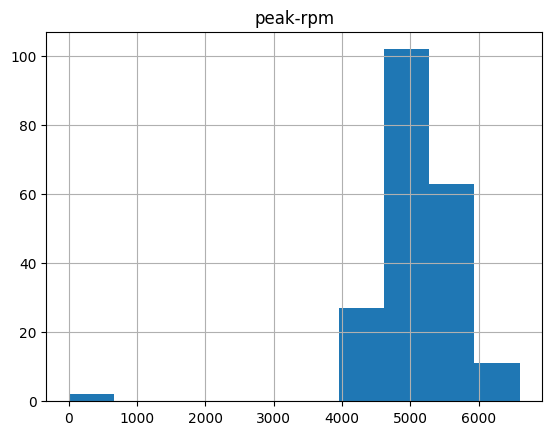

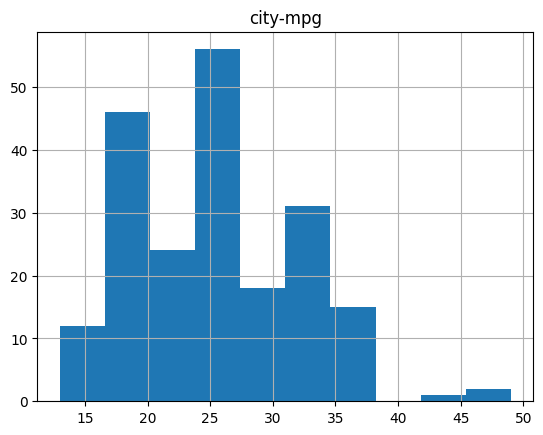

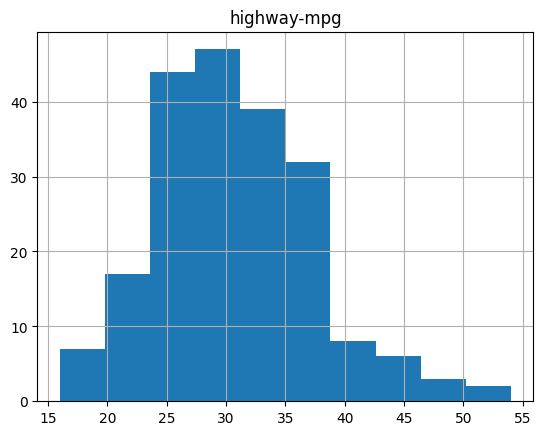

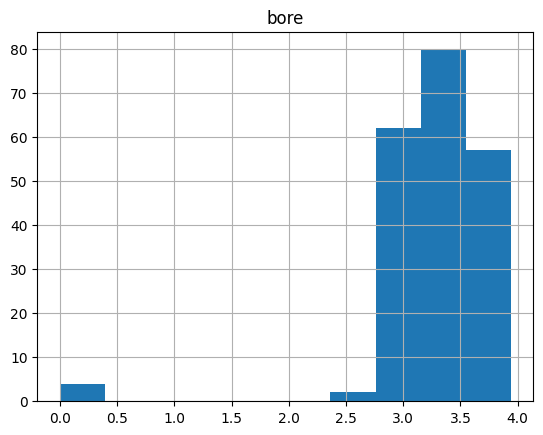

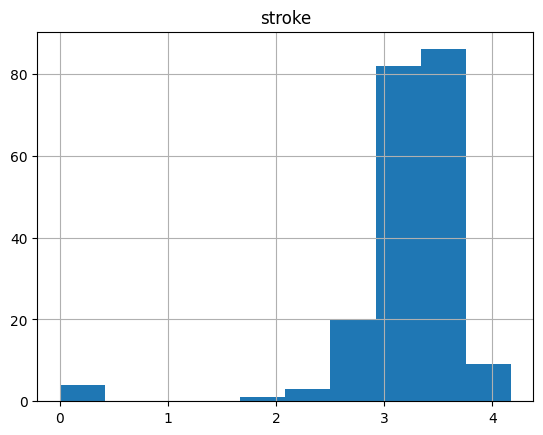

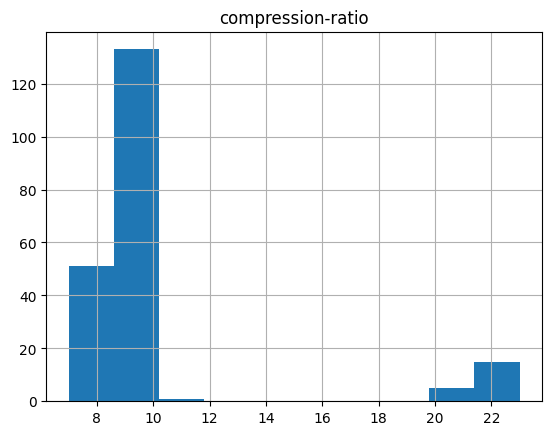

In [16]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [18]:
# Define batch size
batch_size = 16

# Prepare data (categorical features remain unnormalized, numeric features normalized inside the model)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Build a more complex DNN model using Keras with normalization, regularization, and dropout
model = tf.keras.Sequential([
    # Add a normalization layer to normalize the input data during training
    layers.Normalization(input_shape=(x_df.shape[1],)),  # Normalize numeric features
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),  # Dropout layer to reduce overfitting

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),

    layers.Dense(1)  # Output layer for regression
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    x_df.values, y_series.values,  # Ensure input is in numpy format
    epochs=100,  # Set epochs to 100
    batch_size=batch_size,
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model on the test set
eval_dataset = tf.data.Dataset.from_tensor_slices((x_df.values, y_series))
eval_dataset = eval_dataset.batch(batch_size)

# Evaluate the model
loss, mae = model.evaluate(eval_dataset, steps=len(x_df) // batch_size)

print(f"\n✅ Test MSE (Loss): {loss:.2f}")
print(f"✅ Test MAE: {mae:.2f}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 200834048.0000 - mae: 11766.6133 - val_loss: 229535200.0000 - val_mae: 12394.4170
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 171811008.0000 - mae: 10313.4883 - val_loss: 192036288.0000 - val_mae: 10882.6328
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 158534864.0000 - mae: 9429.8594 - val_loss: 154893904.0000 - val_mae: 9119.5225
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 140643072.0000 - mae: 7841.3750 - val_loss: 121234816.0000 - val_mae: 7282.1265
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 76124672.0000 - mae: 5850.2256 - val_loss: 95040544.0000 - val_mae: 6091.1533
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 74052408.0000 - mae: 5798.9331 - val_loss: 80562480.0000 - val_mae: 5639.4033
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 48627756.0000 - mae: 4989.9536 - val_loss: 75861984.0000 - val_mae: 5665.0757
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━

In [ ]:
'''#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)'''

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import numpy as np
import warnings

# Define batch size
batch_size = 16

# Prepare data (categorical features remain unnormalized, numeric features normalized inside the model)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create Interaction Terms (Multiply pairs of features)
# Example interactions: Engine Size × Weight, City MPG × Highway MPG
x_df['engine_size_weight'] = x_df['engine-size'] * x_df['weight']
x_df['city_mpg_highway_mpg'] = x_df['city-mpg'] * x_df['highway-mpg']

# Add these interaction terms to the model input
numeric_feature_names_with_interactions = numeric_feature_names + ['engine_size_weight', 'city_mpg_highway_mpg']

# Build a more complex DNN model using Keras with regularization and dropout
model = tf.keras.Sequential([
    tf.keras.Input(shape=(len(numeric_feature_names_with_interactions),)),  # Input layer (shape inferred from data)

    # First hidden layer with 128 neurons and L2 regularization
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),  # Dropout to reduce overfitting

    # Second hidden layer with 64 neurons
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),

    # Third hidden layer with 32 neurons
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),

    # Output layer for regression
    layers.Dense(1)
])

# Compile the model with a lower learning rate (try even lower, e.g., 0.0001)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    x_df[numeric_feature_names_with_interactions].values, y_series.values,  # Ensure input is in numpy format
    epochs=100,  # Set epochs to 100
    batch_size=batch_size,
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model on the test set
eval_dataset = tf.data.Dataset.from_tensor_slices((x_df[numeric_feature_names_with_interactions].values, y_series))
eval_dataset = eval_dataset.batch(batch_size)

# Evaluate the model
loss, mae = model.evaluate(eval_dataset, steps=len(x_df) // batch_size)

print(f"\n✅ Test MSE (Loss): {loss:.2f}")
print(f"✅ Test MAE: {mae:.2f}")


Epoch 1/100


<ipython-input-20-180f81fb3be6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df['engine_size_weight'] = x_df['engine-size'] * x_df['weight']
<ipython-input-20-180f81fb3be6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df['city_mpg_highway_mpg'] = x_df['city-mpg'] * x_df['highway-mpg']


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 829525568.0000 - mae: 20670.4902 - val_loss: 170594512.0000 - val_mae: 10098.1338
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 603601088.0000 - mae: 17595.8379 - val_loss: 34987712.0000 - val_mae: 3387.4744
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 371164160.0000 - mae: 13917.1924 - val_loss: 99575504.0000 - val_mae: 8116.9038
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 629940032.0000 - mae: 15289.9453 - val_loss: 137174640.0000 - val_mae: 9785.0986
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 319507200.0000 - mae: 12201.0820 - val_loss: 140088064.0000 - val_mae: 9868.9600
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 212653984.0000 - mae: 10688.8408 - val_loss: 87519904.0000 - val_mae: 7473.9990
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 418726592.0000 - mae: 11607.3418 - val_loss: 143777072.0000 - val_mae: 9981.5088
Epoch 8/100
11/11 ━━━━━━━━━━━━━━

In [22]:
'''#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

'''

AttributeError: module 'tensorflow' has no attribute 'estimator'

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [23]:
!pip install -U scikit-learn

In [24]:
!pip install keras

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.optimizers import RMSprop

# Step 1: Prepare data (polynomial features for interaction terms)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create polynomial features up to degree 2 (interaction terms included)
poly = PolynomialFeatures(degree=2, interaction_only=False)
x_poly = poly.fit_transform(x_df)

# Update the feature names to include interaction terms
poly_feature_names = poly.get_feature_names_out(input_features=numeric_feature_names)
x_poly_df = pd.DataFrame(x_poly, columns=poly_feature_names)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_poly_df, y_series, test_size=0.2, random_state=42)

# Step 3: Define the model architecture
def create_model(learning_rate=0.001, dropout_rate=0.2, neurons=64):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(dropout_rate),
        layers.Dense(neurons * 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(dropout_rate),
        layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                  loss='mean_squared_error', metrics=['mae'])
    return model

# Step 4: Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"Training on fold {fold}...")

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Step 5: Train the model on each fold
    model = create_model(learning_rate=0.001, neurons=128, dropout_rate=0.3)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Step 6: Evaluate the model on the validation set
    val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold} - Validation Loss: {val_loss:.2f}, Validation MAE: {val_mae:.2f}")

    fold += 1

# Step 7: Evaluate the model on the test set
final_model = create_model(learning_rate=0.001, neurons=128, dropout_rate=0.3)
final_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the final model
loss, mae = final_model.evaluate(X_test, y_test)
print(f"\n✅ Final Model Test MSE (Loss): {loss:.2f}")
print(f"✅ Final Model Test MAE: {mae:.2f}")


Training on fold 1...
Fold 1 - Validation Loss: 978862528.00, Validation MAE: 30432.32
Training on fold 2...
Fold 2 - Validation Loss: 130101976.00, Validation MAE: 10877.39
Training on fold 3...
Fold 3 - Validation Loss: 279168352.00, Validation MAE: 10706.07
Training on fold 4...
Fold 4 - Validation Loss: 134087912.00, Validation MAE: 9551.13
Training on fold 5...
Fold 5 - Validation Loss: 310926240.00, Validation MAE: 16081.69
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4469536325632.0000 - mae: 1462634.2500 - val_loss: 30420322304.0000 - val_mae: 155014.6406
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 407164977152.0000 - mae: 507876.5000 - val_loss: 491500306432.0000 - val_mae: 683935.6875
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 797452402688.0000 - mae: 719636.6875 - val_loss: 57421824000.0000 - val_mae: 197080.3438
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 325787451392.0000 - mae: 435384.2500 - val_loss: 204960579584.0000 -

In [26]:
'''#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

'''

AttributeError: module 'tensorflow' has no attribute 'estimator'